# Hyper-parameter tuning – Friedman #3 Dataset  
This notebook finds the best parameters for:

* **Bagging** RandomForestRegressor  
* **Boosting** XGBRegressor  
* **Stack meta learner** Ridge α in the RF+XGB+OLS stack

Results are saved to `configs/` folder as yaml files.

## Setup & Imports

In [32]:
from joblib import parallel_backend
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.model_selection import (
    RepeatedKFold,
    KFold,
    train_test_split,
    cross_val_score,
    cross_val_predict,
)
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from optuna.visualization import plot_optimization_history

from bagging_boosting_stacking_study.constants import SEED
from bagging_boosting_stacking_study.data.loaders import load_dataset
from bagging_boosting_stacking_study.configs import save_params, load_params

DATASET_NAME = "friedman3"

In [2]:
# dark theme across plots
pio.templates.default = "plotly_dark"
plt.style.use("dark_background")

## Load Clean Dataset

In [3]:
df = load_dataset(DATASET_NAME, raw=False)

### train test split

In [4]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED)

In [5]:
train_df.shape

(180, 12)

In [6]:
test_df.shape

(20, 12)

## Bagging

### pipeline



### hyper-parameter tuning

In [ ]:
# Split X and y (here X is a DataFrame -- needed for preprocessing in study)
y = train_df["target"].values
X = train_df.drop(columns="target")

# Cross-validation strategy: 10-fold, repeated three times
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=SEED)


# Objective function for Optuna
def objective(trial):
    # Preprocessing choice
    prep_choice = trial.suggest_categorical(
        "prep_choice", ["drop_all_cat", "encode_bin"]
    )

    if prep_choice == "drop_all_cat":
        # Route A: keep only numeric/boolean columns
        numeric_cols = [
            c
            for c in X.columns
            if c
            not in ["feature_2_bin", "feature_2_low", "feature_2_med", "feature_2_high"]
        ]
        preprocess = ColumnTransformer(
            [("num", "passthrough", numeric_cols)], remainder="drop"
        )
        n_features_total = len(numeric_cols)

    else:
        # Route B: ordinal-encode the bin, drop the boolean dummies
        cat_ord = ["feature_2_bin"]
        numeric_cols = [
            c
            for c in X.columns
            if c not in ["feature_2_low", "feature_2_med", "feature_2_high"]
            and c != "feature_2_bin"
        ]
        ord_enc = OrdinalEncoder(categories=[["low", "med", "high"]], dtype=float)
        preprocess = ColumnTransformer(
            [("ord", ord_enc, cat_ord), ("num", "passthrough", numeric_cols)],
            remainder="drop",
        )
        n_features_total = len(numeric_cols) + 1  # +1 for the ordinal col

    # Hyper-parameter search space

    # (a) Ensemble size: enough trees to stabilise predictions; >600 rarely helps here.
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 400, 600])

    # (b) Tree depth: capped depth explores up to 10; 'None' lets the forest grow if CV
    # rewards it.
    if trial.suggest_categorical("cap_depth", [True, False]):
        max_depth = trial.suggest_int("max_depth", 2, 10)
    else:
        max_depth = None

    # (c) Split regularisation: avoid overly eager splitting on tiny groups.
    min_samples_split = trial.suggest_int("min_samples_split", 4, 30, step=2)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 3, 12)

    # (d) Feature subsampling: 2 -> forces interaction discovery from raw cols;
    # 11 -> lets trees see engineered ones.
    max_features = trial.suggest_int("max_features", 2, max(2, n_features_total))

    # (e) Row subsampling / bootstrap
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    max_samples = (
        trial.suggest_float("max_samples", 0.5, 1.0, step=0.1) if bootstrap else None
    )

    # (f) Impurity criterion & pruning
    criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "absolute_error"]
    )
    # Allow stronger cost-complexity pruning (1e-5 → 1e-2) to tame deep trees.
    ccp_alpha = trial.suggest_float("ccp_alpha", 1e-5, 1e-2, log=True)

    # (g) OOB score (only valid if bootstrap)
    oob_score = bootstrap and trial.suggest_categorical("oob_score", [True, False])

    # Model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        max_samples=max_samples,
        criterion=criterion,
        ccp_alpha=ccp_alpha,
        oob_score=oob_score,
        n_jobs=-1,
        random_state=SEED,
    )

    model = Pipeline(
        [
            ("prep", preprocess),
            ("rf", rf),
        ]
    )

    # CV evaluation
    # NOTE: scikit-learn returns negative RMSE so I negate “neg_root_mean_squared_error”
    # again to get a positive value to minimise.
    rmse = -cross_val_score(
        model, X=X, y=y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return rmse


# Create & run the study
study_rf = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),  # reproducible search
    pruner=HyperbandPruner(),  # aggressive early stopping
    study_name=f"RF_{DATASET_NAME}",
)

# Robust search: either n_trials or timeout
study_rf.optimize(objective, n_trials=200, show_progress_bar=True)
# study.optimize(objective, timeout=3600, show_progress_bar=True)

# Inspect the result
print("Best RMSE :", study_rf.best_value)
print("Best parameters:", study_rf.best_params)

[I 2025-05-26 00:45:40,847] A new study created in memory with name: RF_reproducible


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-05-26 00:45:42,573] Trial 0 finished with value: 0.33127739646914256 and parameters: {'prep_choice': 'encode_bin', 'n_estimators': 400, 'cap_depth': True, 'max_depth': 4, 'min_samples_split': 28, 'min_samples_leaf': 3, 'max_features': 2, 'bootstrap': True, 'max_samples': 0.6, 'criterion': 'absolute_error', 'ccp_alpha': 0.00025162039679066454, 'oob_score': False}. Best is trial 0 with value: 0.33127739646914256.
[I 2025-05-26 00:45:44,576] Trial 1 finished with value: 0.3189768945993865 and parameters: {'prep_choice': 'drop_all_cat', 'n_estimators': 600, 'cap_depth': False, 'min_samples_split': 8, 'min_samples_leaf': 11, 'max_features': 3, 'bootstrap': False, 'criterion': 'squared_error', 'ccp_alpha': 2.2673641519996736e-05}. Best is trial 1 with value: 0.3189768945993865.
[I 2025-05-26 00:45:45,342] Trial 2 finished with value: 0.328753140804587 and parameters: {'prep_choice': 'encode_bin', 'n_estimators': 100, 'cap_depth': False, 'min_samples_split': 30, 'min_samples_leaf': 3,

In [22]:
fig = plot_optimization_history(study_rf)
fig.show()

In [23]:
print("Best RMSE :", study_rf.best_value)

Best RMSE : 0.3088824675702392


In [24]:
study_rf.best_params

{'prep_choice': 'drop_all_cat',
 'n_estimators': 600,
 'cap_depth': False,
 'min_samples_split': 22,
 'min_samples_leaf': 7,
 'max_features': 5,
 'bootstrap': False,
 'criterion': 'absolute_error',
 'ccp_alpha': 0.0003661941147008318}

In [25]:
# Save best params to .yaml
save_params(DATASET_NAME, "rf", study_rf.best_value, study_rf.best_params)

Params saved to src\bagging_boosting_stacking_study\configs\friedman3_rf.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/friedman3_rf.yaml')

In [26]:
# Copy Optuna’s best parameters
best_rf_params = study_rf.best_params.copy()
prep_choice = best_rf_params.pop("prep_choice")  # "drop_all_cat" / "encode_bin"
cap_flag = best_rf_params.pop("cap_depth")  # remove it; returns True/False
max_depth = best_rf_params.pop("max_depth", None)  # may or may not exist

best_rf_params["max_depth"] = max_depth if cap_flag else None
best_rf_params.update(
    {
        "random_state": SEED,  # full reproducibility
        "n_jobs": -1,  # or 1 for bit-perfect runs
    }
)

# Fit on all 900 training rows
if prep_choice == "drop_all_cat":
    numeric_cols = [
        c
        for c in train_df.columns
        if c
        not in [
            "target",
            "feature_2_bin",
            "feature_2_low",
            "feature_2_med",
            "feature_2_high",
        ]
    ]
    preprocess = ColumnTransformer(
        [("num", "passthrough", numeric_cols)], remainder="drop"
    )

else:  # 'encode_bin'
    cat_col = ["feature_2_bin"]
    numeric_cols = [
        c
        for c in train_df.columns
        if c
        not in [
            "target",
            "feature_2_low",
            "feature_2_med",
            "feature_2_high",
            "feature_2_bin",
        ]
    ]
    ord_enc = OrdinalEncoder(categories=[["low", "med", "high"]], dtype=float)
    preprocess = ColumnTransformer(
        [("ord", ord_enc, cat_col), ("num", "passthrough", numeric_cols)],
        remainder="drop",
    )

rf_final = Pipeline(
    [
        ("prep", preprocess),
        ("rf", RandomForestRegressor(**best_rf_params)),
    ]
)
rf_final.fit(train_df.drop(columns="target"), train_df["target"])

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['feature_0', 'feature_1',
                                                   'feature_1**2',
                                                   'feature_1*feature_2',
                                                   'feature_2', 'feature_2**2',
                                                   'feature_3'])])),
                ('rf',
                 RandomForestRegressor(bootstrap=False,
                                       ccp_alpha=0.0003661941147008318,
                                       criterion='absolute_error',
                                       max_features=5, min_samples_leaf=7,
                                       min_samples_split=22, n_estimators=600,
                                       n_jobs=-1, random_state=333))])

## Boosting

In [ ]:
# Split X and y (here X is a DataFrame -- needed for preprocessing in study)
y = train_df["target"].values
X = train_df.drop(columns="target")

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=SEED)


# Objective function
def objective(trial):
    # Preprocessing choice
    prep_choice = trial.suggest_categorical(
        "prep_choice", ["drop_all_cat", "encode_bin"]
    )

    if prep_choice == "drop_all_cat":
        # keep strictly numeric/boolean columns
        numeric_cols = [
            c
            for c in X.columns
            if c
            not in ["feature_2_bin", "feature_2_low", "feature_2_med", "feature_2_high"]
        ]
        preprocess = ColumnTransformer(
            [("num", "passthrough", numeric_cols)], remainder="drop"
        )
        n_feat = len(numeric_cols)

    else:  # "encode_bin"
        # ordinal-encode the bin, drop the dummy flags
        cat_col = ["feature_2_bin"]
        numeric_cols = [
            c
            for c in X.columns
            if c
            not in ["feature_2_low", "feature_2_med", "feature_2_high", "feature_2_bin"]
        ]
        ord_enc = OrdinalEncoder(
            categories=[["low", "med", "high"]], dtype=float  # enforces the order
        )
        preprocess = ColumnTransformer(
            [("ord", ord_enc, cat_col), ("num", "passthrough", numeric_cols)],
            remainder="drop",
        )
        n_feat = len(numeric_cols) + 1  # +1 ordinal

    # Search space

    # Ensemble size — >800 rarely helps with 180 rows
    n_estimators = trial.suggest_int("n_estimators", 50, 800, step=50)

    # Learning rate — allow slower (0.01) but not ultra-slow (0.001) to keep runtime sane
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)

    # Depth or leaf-based growth
    grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if grow_policy == "depthwise":
        max_depth = trial.suggest_int("max_depth", 2, 10)
        max_leaves = 0  # ignored
    else:  # lossguide (leaf-wise)
        max_depth = 0
        max_leaves = trial.suggest_int("max_leaves", 16, 128, step=16)  # small caps

    # Child-weight regularisation — >= 1 discourages overly specific leaves
    min_child_weight = trial.suggest_float("min_child_weight", 1.0, 20.0, log=True)

    # Row & column subsampling for variance control
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float(
        "colsample_bytree", 0.4, min(1.0, max(0.4, n_feat / 12)), step=0.1
    )
    # (if all 12 features survive, upper bound is 1.0; else it's lower)

    # Regularisation terms
    reg_lambda = trial.suggest_float("reg_lambda", 1e-2, 20.0, log=True)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 5.0)
    gamma = trial.suggest_float("gamma", 0.0, 5.0)  # min loss-reduction to split

    # A gentle safety knob; rarely fires in regression but costs nothing
    max_delta_step = trial.suggest_int("max_delta_step", 0, 5)

    # Build the Pipeline with XGB model
    xgb = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        max_delta_step=max_delta_step,
        grow_policy=grow_policy,
        objective="reg:squarederror",
        tree_method="hist",
        random_state=SEED,
        n_jobs=-1,
    )

    model = Pipeline(
        [
            ("prep", preprocess),
            ("xgb", xgb),
        ]
    )

    # CV evaluation (neg RMSE -> minimise RMSE)
    rmse = -cross_val_score(
        model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1
    ).mean()

    return rmse


# Create & run the Optuna study
study_xgb = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),
    pruner=HyperbandPruner(),  # stops weak configs early
    study_name=f"XGB_{DATASET_NAME}",
)

study_xgb.optimize(objective, n_trials=500, show_progress_bar=True)
# study.optimize(objective, timeout=3600, show_progress_bar=True)

print("Best RMSE :", study_xgb.best_value)
print("Best parameters:", study_xgb.best_params)

[I 2025-05-26 00:57:20,234] A new study created in memory with name: XGB_friedman3


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\code\venvs\repos\repo-3.12-bagging-boosting-stacking-study\Lib\site-packages\optuna\distributions.py:684: UserWarning:

The distribution is specified by [0.4, 0.6666666666666666] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.4, 0.6].



[I 2025-05-26 00:57:22,117] Trial 0 finished with value: 0.34234246797724543 and parameters: {'prep_choice': 'encode_bin', 'n_estimators': 50, 'learning_rate': 0.02690175984163535, 'grow_policy': 'depthwise', 'max_depth': 2, 'min_child_weight': 1.338964709081891, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_lambda': 0.01480374410896347, 'reg_alpha': 0.3024066786659457, 'gamma': 1.193700568007332, 'max_delta_step': 1}. Best is trial 0 with value: 0.34234246797724543.
[I 2025-05-26 00:57:22,379] Trial 1 finished with value: 0.3146137098878819 and parameters: {'prep_choice': 'encode_bin', 'n_estimators': 800, 'learning_rate': 0.04050146997666838, 'grow_policy': 'lossguide', 'max_leaves': 96, 'min_child_weight': 4.265756196780509, 'subsample': 0.5, 'colsample_bytree': 0.4, 'reg_lambda': 0.013788632235488887, 'reg_alpha': 1.220654993768104, 'gamma': 0.3575852807319324, 'max_delta_step': 5}. Best is trial 1 with value: 0.3146137098878819.
[I 2025-05-26 00:57:22,488] Trial 2 finished with 

c:\code\venvs\repos\repo-3.12-bagging-boosting-stacking-study\Lib\site-packages\optuna\distributions.py:684: UserWarning:

The distribution is specified by [0.4, 0.5833333333333334] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.4, 0.5].



[I 2025-05-26 00:57:23,038] Trial 6 finished with value: 0.34294612187729917 and parameters: {'prep_choice': 'drop_all_cat', 'n_estimators': 100, 'learning_rate': 0.0330265771988417, 'grow_policy': 'lossguide', 'max_leaves': 64, 'min_child_weight': 11.029309077316556, 'subsample': 0.7, 'colsample_bytree': 0.5, 'reg_lambda': 0.33269396785123356, 'reg_alpha': 2.399400016277016, 'gamma': 0.7022317263574518, 'max_delta_step': 4}. Best is trial 1 with value: 0.3146137098878819.
[I 2025-05-26 00:57:23,271] Trial 7 finished with value: 0.3743242556866147 and parameters: {'prep_choice': 'drop_all_cat', 'n_estimators': 750, 'learning_rate': 0.01795055952362266, 'grow_policy': 'depthwise', 'max_depth': 2, 'min_child_weight': 12.187917126780798, 'subsample': 0.5, 'colsample_bytree': 0.4, 'reg_lambda': 1.9176625773714457, 'reg_alpha': 4.631415048692398, 'gamma': 1.6099943051795278, 'max_delta_step': 5}. Best is trial 1 with value: 0.3146137098878819.
[I 2025-05-26 00:57:23,345] Trial 8 finished wi

In [28]:
fig = plot_optimization_history(study_xgb)
fig.show()

In [36]:
print("Best RMSE :", study_xgb.best_value)

Best RMSE : 0.30738177927042776


In [35]:
study_xgb.best_params

{'prep_choice': 'encode_bin',
 'n_estimators': 300,
 'learning_rate': 0.016640139108054803,
 'grow_policy': 'depthwise',
 'max_depth': 2,
 'min_child_weight': 3.6048147441644027,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'reg_lambda': 0.11745234827436017,
 'reg_alpha': 0.5075478677581529,
 'gamma': 0.09026975868411022,
 'max_delta_step': 1}

In [34]:
# Save best params to .yaml
save_params(DATASET_NAME, "xgb", study_xgb.best_value, study_xgb.best_params)

Params saved to src\bagging_boosting_stacking_study\configs\friedman3_xgb.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/friedman3_xgb.yaml')

In [25]:
best_params = study_xgb.best_params.copy()
best_params.update(
    {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "random_state": SEED,
        "n_jobs": -1,
    }
)
xgb_final = XGBRegressor(**best_params)
xgb_final.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.4511270522982942,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, learning_rate=0.02010903042778187,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=3, max_depth=2, max_leaves=None,
             min_child_weight=0.5318510238039913, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [31]:
# -------------------------------------------------------------
# Re-create the full training pipeline using Optuna’s best trial
# -------------------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# 1 ▸ pull out everything Optuna found
best_params = study_xgb.best_params.copy()
prep_choice = best_params.pop("prep_choice")

grow_policy = best_params["grow_policy"]
if grow_policy == "depthwise":
    best_params["max_leaves"] = 0  # ignored in depthwise
else:  # 'lossguide'
    best_params["max_depth"] = 0  # depth cap disabled

best_params.update(
    dict(
        objective="reg:squarederror",
        tree_method="hist",
        random_state=SEED,
        n_jobs=-1,
    )
)

if prep_choice == "drop_all_cat":
    numeric_cols = [
        c
        for c in train_df.columns
        if c
        not in [
            "target",
            "feature_2_bin",
            "feature_2_low",
            "feature_2_med",
            "feature_2_high",
        ]
    ]
    preprocess = ColumnTransformer(
        [("num", "passthrough", numeric_cols)],
        remainder="drop",
    )

else:  # "encode_bin"
    cat_col = ["feature_2_bin"]
    numeric_cols = [
        c
        for c in train_df.columns
        if c
        not in [
            "target",
            "feature_2_low",
            "feature_2_med",
            "feature_2_high",
            "feature_2_bin",
        ]
    ]
    preprocess = ColumnTransformer(
        [
            (
                "ord",
                OrdinalEncoder(categories=[["low", "med", "high"]], dtype=float),
                cat_col,
            ),
            ("num", "passthrough", numeric_cols),
        ],
        remainder="drop",
    )


xgb_final = Pipeline(
    steps=[
        ("prep", preprocess),
        ("xgb", XGBRegressor(**best_params)),
    ]
)
xgb_final.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'med',
                                                                              'high']],
                                                                 dtype=<class 'float'>),
                                                  ['feature_2_bin']),
                                                 ('num', 'passthrough',
                                                  ['feature_0', 'feature_1',
                                                   'feature_1**2',
                                                   'feature_1*feature_2',
                                                   'feature_2', 'feature_2**2',
                                                   'feature_3'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsam...
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.016640139108054803, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=1, max_depth=2, max_leaves=0,
                              min_child_weight=3.6048147441644027, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=-1,
                              num_parallel_tree=None, ...))])

## Stacking

In [42]:
y = train_df["target"].values
X = train_df.drop(columns="target")  # keep DF for column names


def make_preprocessor(prep_choice: str) -> ColumnTransformer:
    """
    Return a ColumnTransformer implementing either
    • 'drop_all_cat' - keep numeric/bool only
    • 'encode_bin' - ordinal-encode feature_2_bin, drop dummy flags
    """
    if prep_choice == "drop_all_cat":   # drop all branch
        numeric_cols = [
            c
            for c in X.columns
            if c
            not in ["feature_2_bin", "feature_2_low", "feature_2_med", "feature_2_high"]
        ]
        return ColumnTransformer(
            [("num", "passthrough", numeric_cols)], remainder="drop"
        )

    # encode_bin branch
    cat_col = ["feature_2_bin"]
    numeric_cols = [
        c
        for c in X.columns
        if c
        not in ["feature_2_low", "feature_2_med", "feature_2_high", "feature_2_bin"]
    ]
    return ColumnTransformer(
        [
            (
                "ord",
                OrdinalEncoder(categories=[["low", "med", "high"]], dtype=float),
                cat_col,
            ),
            ("num", "passthrough", numeric_cols),
        ],
        remainder="drop",
    )


# Base Learners

# (a) Random Forest
rf_best = load_params(dataset=DATASET_NAME, model="rf")["params"]
prep_choice_rf = rf_best.pop("prep_choice")  # pull out meta-param
cap_flag = rf_best.pop("cap_depth")
rf_best["max_depth"] = rf_best.pop("max_depth", None) if cap_flag else None
rf_best.update(dict(random_state=SEED, n_jobs=-1))

rf_pipeline = Pipeline(
    steps=[
        ("prep", make_preprocessor(prep_choice_rf)),
        ("rf", RandomForestRegressor(**rf_best)),
    ]
)

# (b) XGBoost
xgb_best = load_params(dataset=DATASET_NAME, model="xgb")["params"]
prep_choice_xgb = xgb_best.pop("prep_choice")
# align depth / leaves with grow_policy
if xgb_best["grow_policy"] == "depthwise":
    xgb_best["max_leaves"] = 0
else:
    xgb_best["max_depth"] = 0

xgb_best.update(
    dict(objective="reg:squarederror", tree_method="hist", random_state=SEED, n_jobs=-1)
)

xgb_pipeline = Pipeline(
    steps=[
        ("prep", make_preprocessor(prep_choice_xgb)),
        ("xgb", XGBRegressor(**xgb_best)),
    ]
)

# (c) OLS (with standardisation)
# use whichever preprocessing XGBoost picked (any numeric output is fine)
ols_pipeline = Pipeline(
    steps=[
        ("prep", make_preprocessor(prep_choice_xgb)),  # reuse to keep columns identical
        ("sc", StandardScaler()),
        ("ols", LinearRegression()),
    ]
)

base_estimators = [
    ("rf", rf_pipeline),
    ("xgb", xgb_pipeline),
    ("ols", ols_pipeline),
]

cv = KFold(n_splits=10, shuffle=True, random_state=SEED)  # 18 rows / fold

preds = []
with parallel_backend("loky"):  # respects each model's internal n_jobs
    for name, est in tqdm(base_estimators, desc="OOF learners"):
        # For Pipeline we need to tweak only the final step's n_jobs if we wish, but 
        # cross_val_predict will parallelise across folds anyway.
        oof = cross_val_predict(est, X, y, cv=cv, n_jobs=-1, verbose=0)
        preds.append(oof)

X_meta = np.column_stack(preds)

# Ridge meta learner
alphas = np.concatenate(([0.0], np.logspace(-8, 2, 500)))
ridge_cv = RidgeCV(
    alphas=alphas, cv=cv, scoring="neg_root_mean_squared_error", store_cv_results=False
).fit(X_meta, y)

best_alpha = ridge_cv.alpha_
best_rmse = np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta)))

print(f"Chosen alpha: {best_alpha:.4g}")
print(f"OOF RMSE    : {best_rmse:.5f}")

OOF learners:   0%|          | 0/3 [00:00<?, ?it/s]

Chosen alpha: 1.98
OOF RMSE    : 0.31242


In [43]:
print(f"Best RMSE: {np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta)))}")

Best RMSE: 0.31242055484138775


In [44]:
print(f"Best lambda (alpha): {ridge_cv.alpha_}")

Best lambda (alpha): 1.9796717529513286


In [40]:
# Save best params to .yaml
save_params(
    dataset=DATASET_NAME, 
    model="stack", 
    metric=np.sqrt(mean_squared_error(y, ridge_cv.predict(X_meta))), 
    params={"alpha": float(ridge_cv.alpha_)}
)

Params saved to src\bagging_boosting_stacking_study\configs\friedman3_stack.yaml


WindowsPath('C:/code/repos/bagging-boosting-stacking-study/src/bagging_boosting_stacking_study/configs/friedman3_stack.yaml')

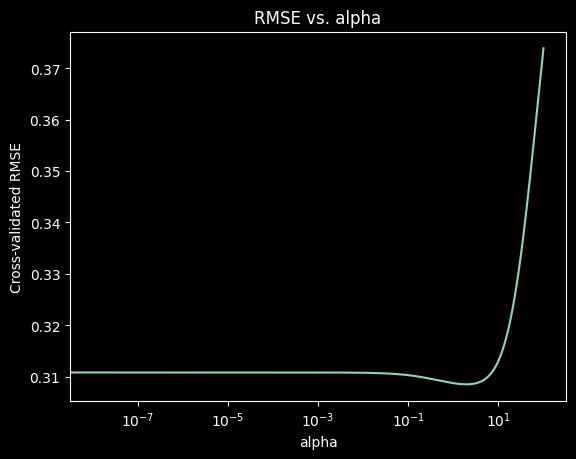

In [45]:
rmses = []
for a in alphas:
    scores = cross_val_score(
        Ridge(alpha=a),
        X_meta,
        y,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
    rmses.append(-scores.mean())

plt.figure()
plt.xscale("log")
plt.plot(alphas, rmses)
plt.xlabel("alpha")
plt.ylabel("Cross-validated RMSE")
plt.title("RMSE vs. alpha")
plt.show()

In [49]:
alphas[np.argmin(rmses)]

np.float64(1.9796717529513286)

In [50]:
best_alpha = ridge_cv.alpha_
meta_final = Pipeline(
    steps=[
        ("sc", StandardScaler()),  # scale the three OOF columns
        ("ridge", Ridge(alpha=best_alpha, random_state=SEED)),
    ]
)

stack_final = StackingRegressor(
    estimators=base_estimators,  # rf_pipeline, xgb_pipeline, ols_pipeline
    final_estimator=meta_final,
    cv=cv,  # same 10-fold KFold used for OOF
    passthrough=False,  # meta sees only base predictions
    n_jobs=-1,
)

X_full_df = train_df.drop(columns="target")  # keep column names for pipelines
y_full = train_df["target"].values

stack_final.fit(X, y)

StackingRegressor(cv=KFold(n_splits=10, random_state=333, shuffle=True),
                  estimators=[('rf',
                               Pipeline(steps=[('prep',
                                                ColumnTransformer(transformers=[('num',
                                                                                 'passthrough',
                                                                                 ['feature_0',
                                                                                  'feature_1',
                                                                                  'feature_1**2',
                                                                                  'feature_1*feature_2',
                                                                                  'feature_2',
                                                                                  'feature_2**2',
                                                                                  'feature_3'])])),
                                               ('rf',
                                                RandomForestRegressor(bootstrap=False,
                                                                      ccp_alpha=0.0003661941147008318,
                                                                      cri...
                                                                                                dtype=<class 'float'>),
                                                                                 ['feature_2_bin']),
                                                                                ('num',
                                                                                 'passthrough',
                                                                                 ['feature_0',
                                                                                  'feature_1',
                                                                                  'feature_1**2',
                                                                                  'feature_1*feature_2',
                                                                                  'feature_2',
                                                                                  'feature_2**2',
                                                                                  'feature_3'])])),
                                               ('sc', StandardScaler()),
                                               ('ols', LinearRegression())]))],
                  final_estimator=Pipeline(steps=[('sc', StandardScaler()),
                                                  ('ridge',
                                                   Ridge(alpha=np.float64(1.9796717529513286),
                                                         random_state=333))]),
                  n_jobs=-1)